In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Unsupervised Learning Models

In [ ]:
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score

# load the cleaned weather dataset
weather_data = pd.read_csv("../data/weather/city_data/BUDAPEST.csv")

print(weather_data.isnull().sum())
#select features for clustering excluding the date column
features = weather_data.drop(columns=['DATE','BUDAPEST_picnic_weather'],axis=1)
scaler = StandardScaler()
normalized_features = scaler.fit_transform(features)
print(normalized_features[:5])

## Determining the Optimal Number of Clusters/Components
### KMeans 

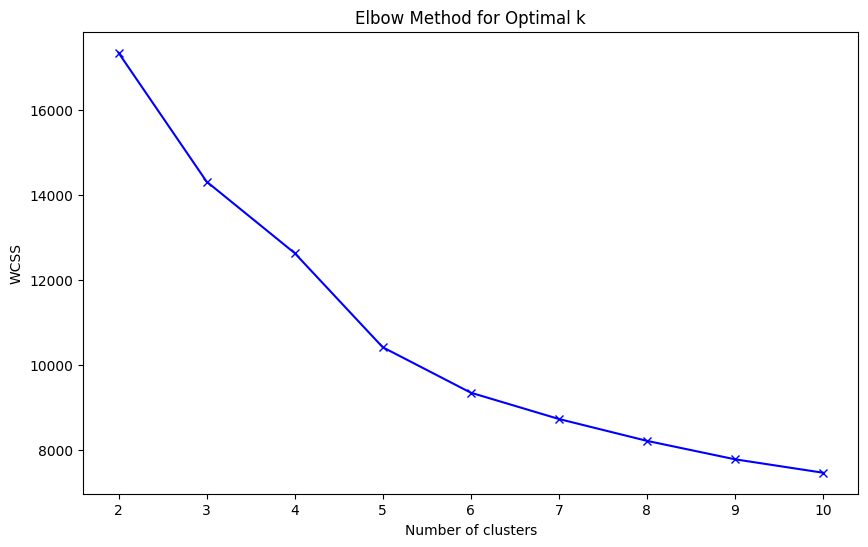

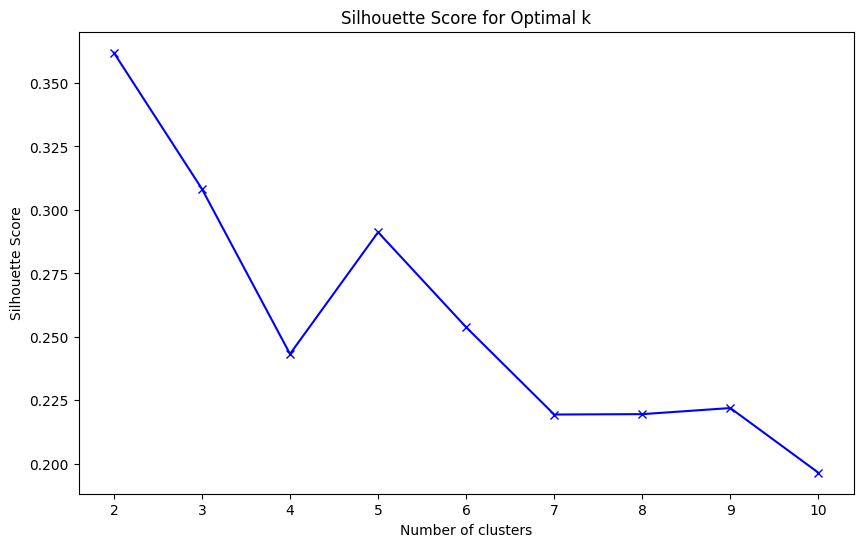

Optimal number of clusters for weather data: 2


In [4]:
from sklearn.cluster import KMeans

# function to find optimal number of clusters
def optimal_kmeans_clusters(features):
    wcss = []
    silhouette_scores = []
    cluster_range = range(2,11)
    for k in cluster_range:
        kmeans = KMeans(n_clusters=k,random_state=42)
        kmeans.fit(features)
        wcss.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(features,kmeans.labels_))
    
    plt.figure(figsize=(10,6))
    plt.plot(cluster_range,wcss,'bx-')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.title('Elbow Method for Optimal k')
    plt.show()

    plt.figure(figsize=(10,6))
    plt.plot(cluster_range,silhouette_scores,'bx-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score for Optimal k')
    plt.show()

    optimal_k = cluster_range[np.argmax(silhouette_scores)]
    return optimal_k

#Determining the optimal number of clusters
optimal_k = optimal_kmeans_clusters(normalized_features)
print(f'Optimal number of clusters for weather data: {optimal_k}')


### Gaussian Mixture Model (EM)

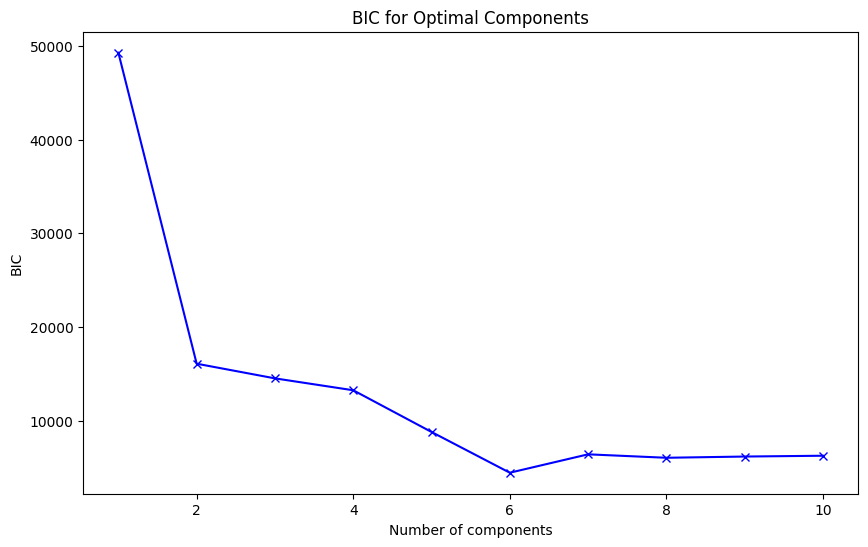

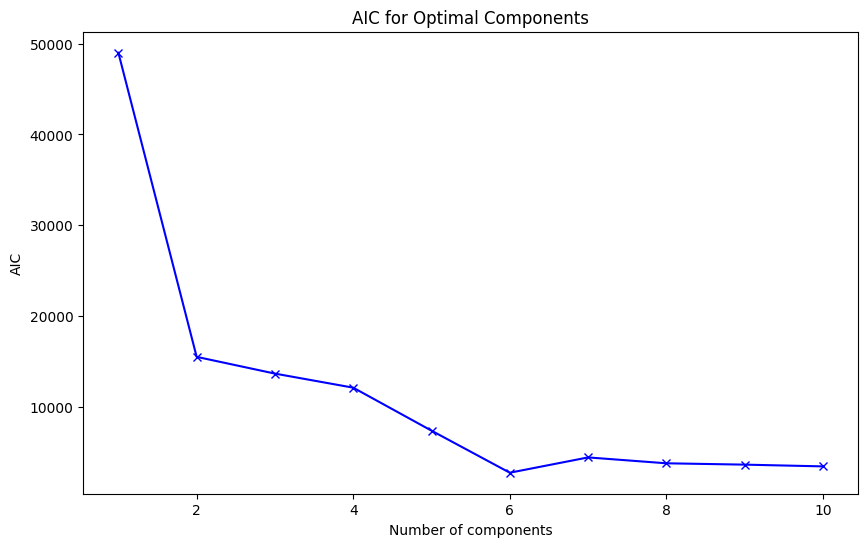

Optimal number of components for weather data using BIC: 6
Optimal number of components for weather data using AIC: 6


In [5]:
# find optimal components for GMM
def optimal_gmm_components(features):
    bic_scores = [] # Bayesian Information Criterion
    aic_scores = [] # Akaike Information Criterion
    component_range = range(1,11)
    for i in component_range:
        gmm = GaussianMixture(n_components=i,random_state=42)
        gmm.fit(features)
        bic_scores.append(gmm.bic(features))
        aic_scores.append(gmm.aic(features))
    
    plt.figure(figsize=(10,6))
    plt.plot(component_range,bic_scores,'bx-')
    plt.xlabel('Number of components')
    plt.ylabel('BIC')
    plt.title('BIC for Optimal Components')
    plt.show()

    plt.figure(figsize=(10,6))
    plt.plot(component_range,aic_scores,'bx-')
    plt.xlabel('Number of components')
    plt.ylabel('AIC')
    plt.title('AIC for Optimal Components')
    plt.show()

    optimal_components_bic = component_range[np.argmin(bic_scores)]
    optimal_components_aic = component_range[np.argmin(aic_scores)]
    return optimal_components_bic,optimal_components_aic

#determine the optimal number of components for GMM
optimal_components_bic,optimal_components_aic = optimal_gmm_components(normalized_features)
print(f'Optimal number of components for weather data using BIC: {optimal_components_bic}')
print(f'Optimal number of components for weather data using AIC: {optimal_components_aic}')


## Running Clustering Algorithms

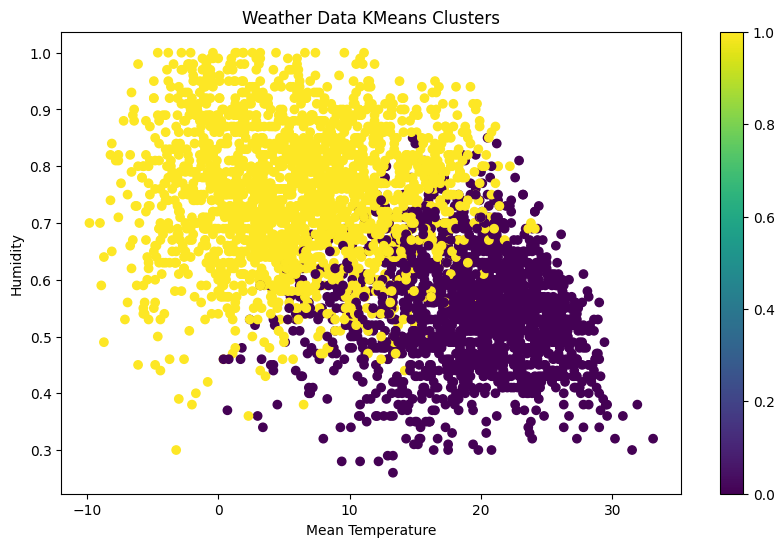

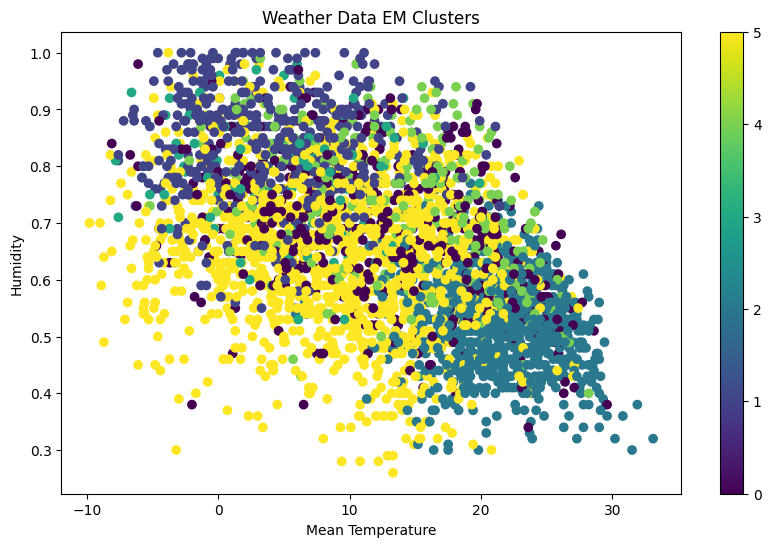

In [6]:
kmeans_weather = KMeans(n_clusters=optimal_k, random_state=42)
weather_kmeans_clusters = kmeans_weather.fit_predict(normalized_features)

# Add cluster labels to original dataset
weather_data['KMeans_Cluster'] = weather_kmeans_clusters

# Plot KMeans Clusters
plt.figure(figsize=(10, 6))
plt.scatter(weather_data['BUDAPEST_temp_mean'], weather_data['BUDAPEST_humidity'], c=weather_kmeans_clusters, cmap='viridis', marker='o')
plt.xlabel('Mean Temperature')
plt.ylabel('Humidity')
plt.title('Weather Data KMeans Clusters')
plt.colorbar()
plt.show()
# Run GMM with optimal number of components
em_weather = GaussianMixture(n_components=optimal_components_bic,random_state=42)
weather_em_clusters = em_weather.fit_predict(normalized_features)

# add the cluster labels to the original dataset
weather_data['EM_Cluster'] = weather_em_clusters

# Plot EM Clusters
plt.figure(figsize=(10, 6))
plt.scatter(weather_data['BUDAPEST_temp_mean'], weather_data['BUDAPEST_humidity'], c=weather_em_clusters, cmap='viridis', marker='o')
plt.xlabel('Mean Temperature')
plt.ylabel('Humidity')
plt.title('Weather Data EM Clusters')
plt.colorbar()
plt.show()

## Performing Dimensionality Reduction Algorithms on Weather Dataset

#### Principal Component Analysis (PCA)

In [8]:
from sklearn.decomposition import PCA
# determine optimal number of components for PCA
def optimal_pca_components(features):
    pca = PCA()
    pca.fit(features)
    explained_variance = np.cumsum(pca.explained_variance_ratio_)

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Explained Variance vs. Number of Components (PCA)')
    plt.grid(True)
    plt.show()

    # Choose the number of components that explain a sufficient amount of variance
    n_components = np.argmax(explained_variance >= 0.95) + 1
    pca = PCA(n_components=n_components)
    pca_transformed = pca.fit_transform(features)
    return pca_transformed, n_components

#### Independent Component Analysis (ICA)

In [9]:
from sklearn.decomposition import FastICA
from scipy.stats import kurtosis

# determine optimal number of components for ICA
def optimal_ica_components(features):
    ica = FastICA(random_state=42)
    kurtosis_scores = []
    component_range = range(2, 11)
    for i in component_range:
        ica.set_params(n_components=i)
        components = ica.fit_transform(features)
        kurtosis_scores.append(np.mean(np.abs(kurtosis(components, fisher=False))))

    plt.figure(figsize=(10, 6))
    plt.plot(component_range, kurtosis_scores, marker='o')
    plt.xlabel('Number of components')
    plt.ylabel('Average Kurtosis')
    plt.title('Average Kurtosis vs. Optimal Number of Components (ICA)')
    plt.show()

    optimal_components = component_range[np.argmax(kurtosis_scores)]
    ica = FastICA(n_components=optimal_components, random_state=42)
    ica_transformed = ica.fit_transform(features)
    return ica_transformed, optimal_components

#### Random Projection (RP)

In [10]:
from sklearn.random_projection import GaussianRandomProjection
from sklearn.metrics import mean_squared_error

def apply_rp(features):
    reconstruction_errors = []
    component_range = range(2, 11)
    for n in component_range:
        rp = GaussianRandomProjection(n_components=n, random_state=42)
        projected = rp.fit_transform(features)
        reconstructed = np.dot(projected, np.linalg.pinv(rp.components_).T)
        error = mean_squared_error(features, reconstructed)
        reconstruction_errors.append(error)
    
    plt.figure(figsize=(10, 6))
    plt.plot(component_range, reconstruction_errors, marker='o')
    plt.xlabel('Number of Components')
    plt.ylabel('Reconstruction Error')
    plt.title('Reconstruction Error vs. Number of Components (RP)')
    plt.grid(True)
    plt.show()
    
    # Choose the number of components that minimize reconstruction error
    n_components = component_range[np.argmin(reconstruction_errors)]
    rp = GaussianRandomProjection(n_components=n_components, random_state=42)
    rp_transformed = rp.fit_transform(features)
    return rp_transformed, n_components

#### Apply PCA, ICA, RP to Housing Dataset

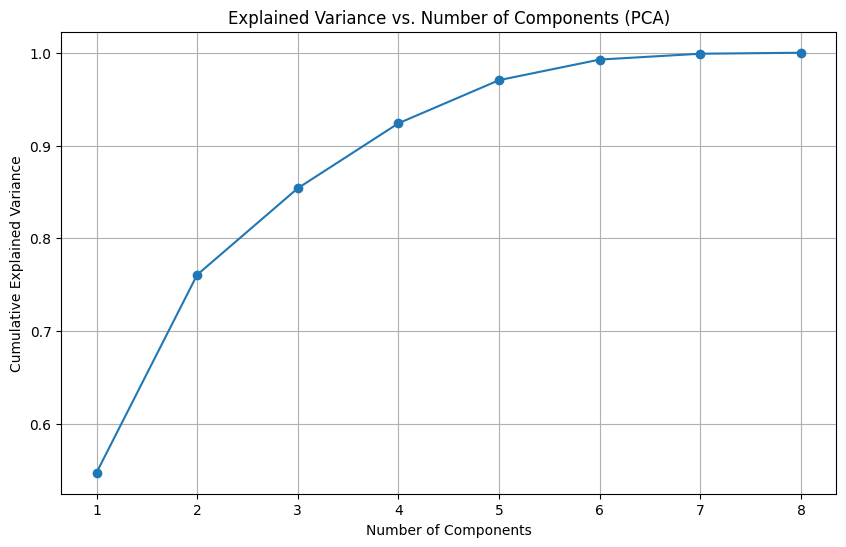

/Users/atomar/Desktop/CSE 7641_ML/Housing_Weather_UL_Dim_Reduction/venv/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:595: UserWarning: n_components is too large: it will be set to 8
  warnings.warn(
/Users/atomar/Desktop/CSE 7641_ML/Housing_Weather_UL_Dim_Reduction/venv/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:595: UserWarning: n_components is too large: it will be set to 8
  warnings.warn(


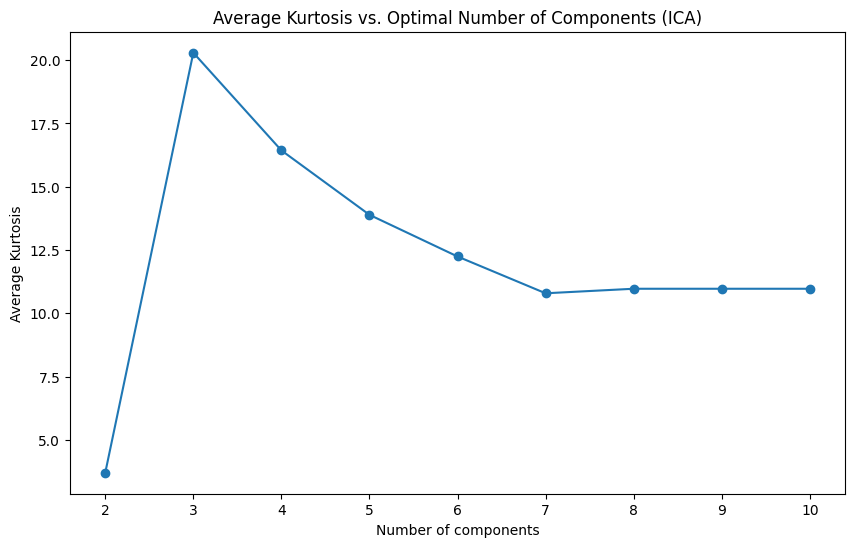

/Users/atomar/Desktop/CSE 7641_ML/Housing_Weather_UL_Dim_Reduction/venv/lib/python3.9/site-packages/sklearn/random_projection.py:408: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (8 < 9).The dimensionality of the problem will not be reduced.
  warnings.warn(
/Users/atomar/Desktop/CSE 7641_ML/Housing_Weather_UL_Dim_Reduction/venv/lib/python3.9/site-packages/sklearn/random_projection.py:408: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (8 < 10).The dimensionality of the problem will not be reduced.
  warnings.warn(


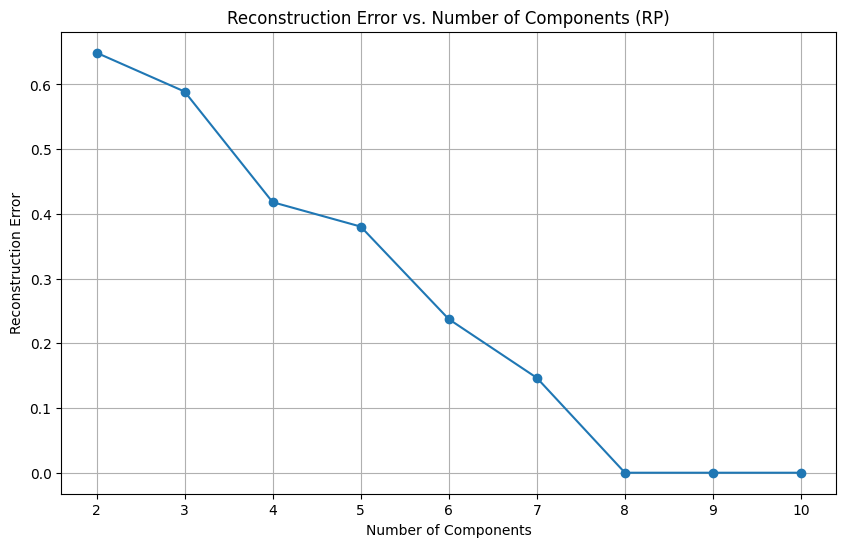

/Users/atomar/Desktop/CSE 7641_ML/Housing_Weather_UL_Dim_Reduction/venv/lib/python3.9/site-packages/sklearn/random_projection.py:408: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (8 < 10).The dimensionality of the problem will not be reduced.
  warnings.warn(
/var/folders/m3/r7hwf1fs777chjp132q4bwlh0000gp/T/ipykernel_51614/230173668.py:7: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axes[0,0].scatter(pca_weather[:, 0], pca_weather[:, 1], cmap='viridis', marker='o')
/var/folders/m3/r7hwf1fs777chjp132q4bwlh0000gp/T/ipykernel_51614/230173668.py:12: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axes[1,0].scatter(ica_weather[:, 0], ica_weather[:, 1], cmap='viridis', marker='o')
/var/folders/m3/r7hwf1fs777chjp132q4bwlh0000gp/T/ipykernel_51614/230173668.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cma

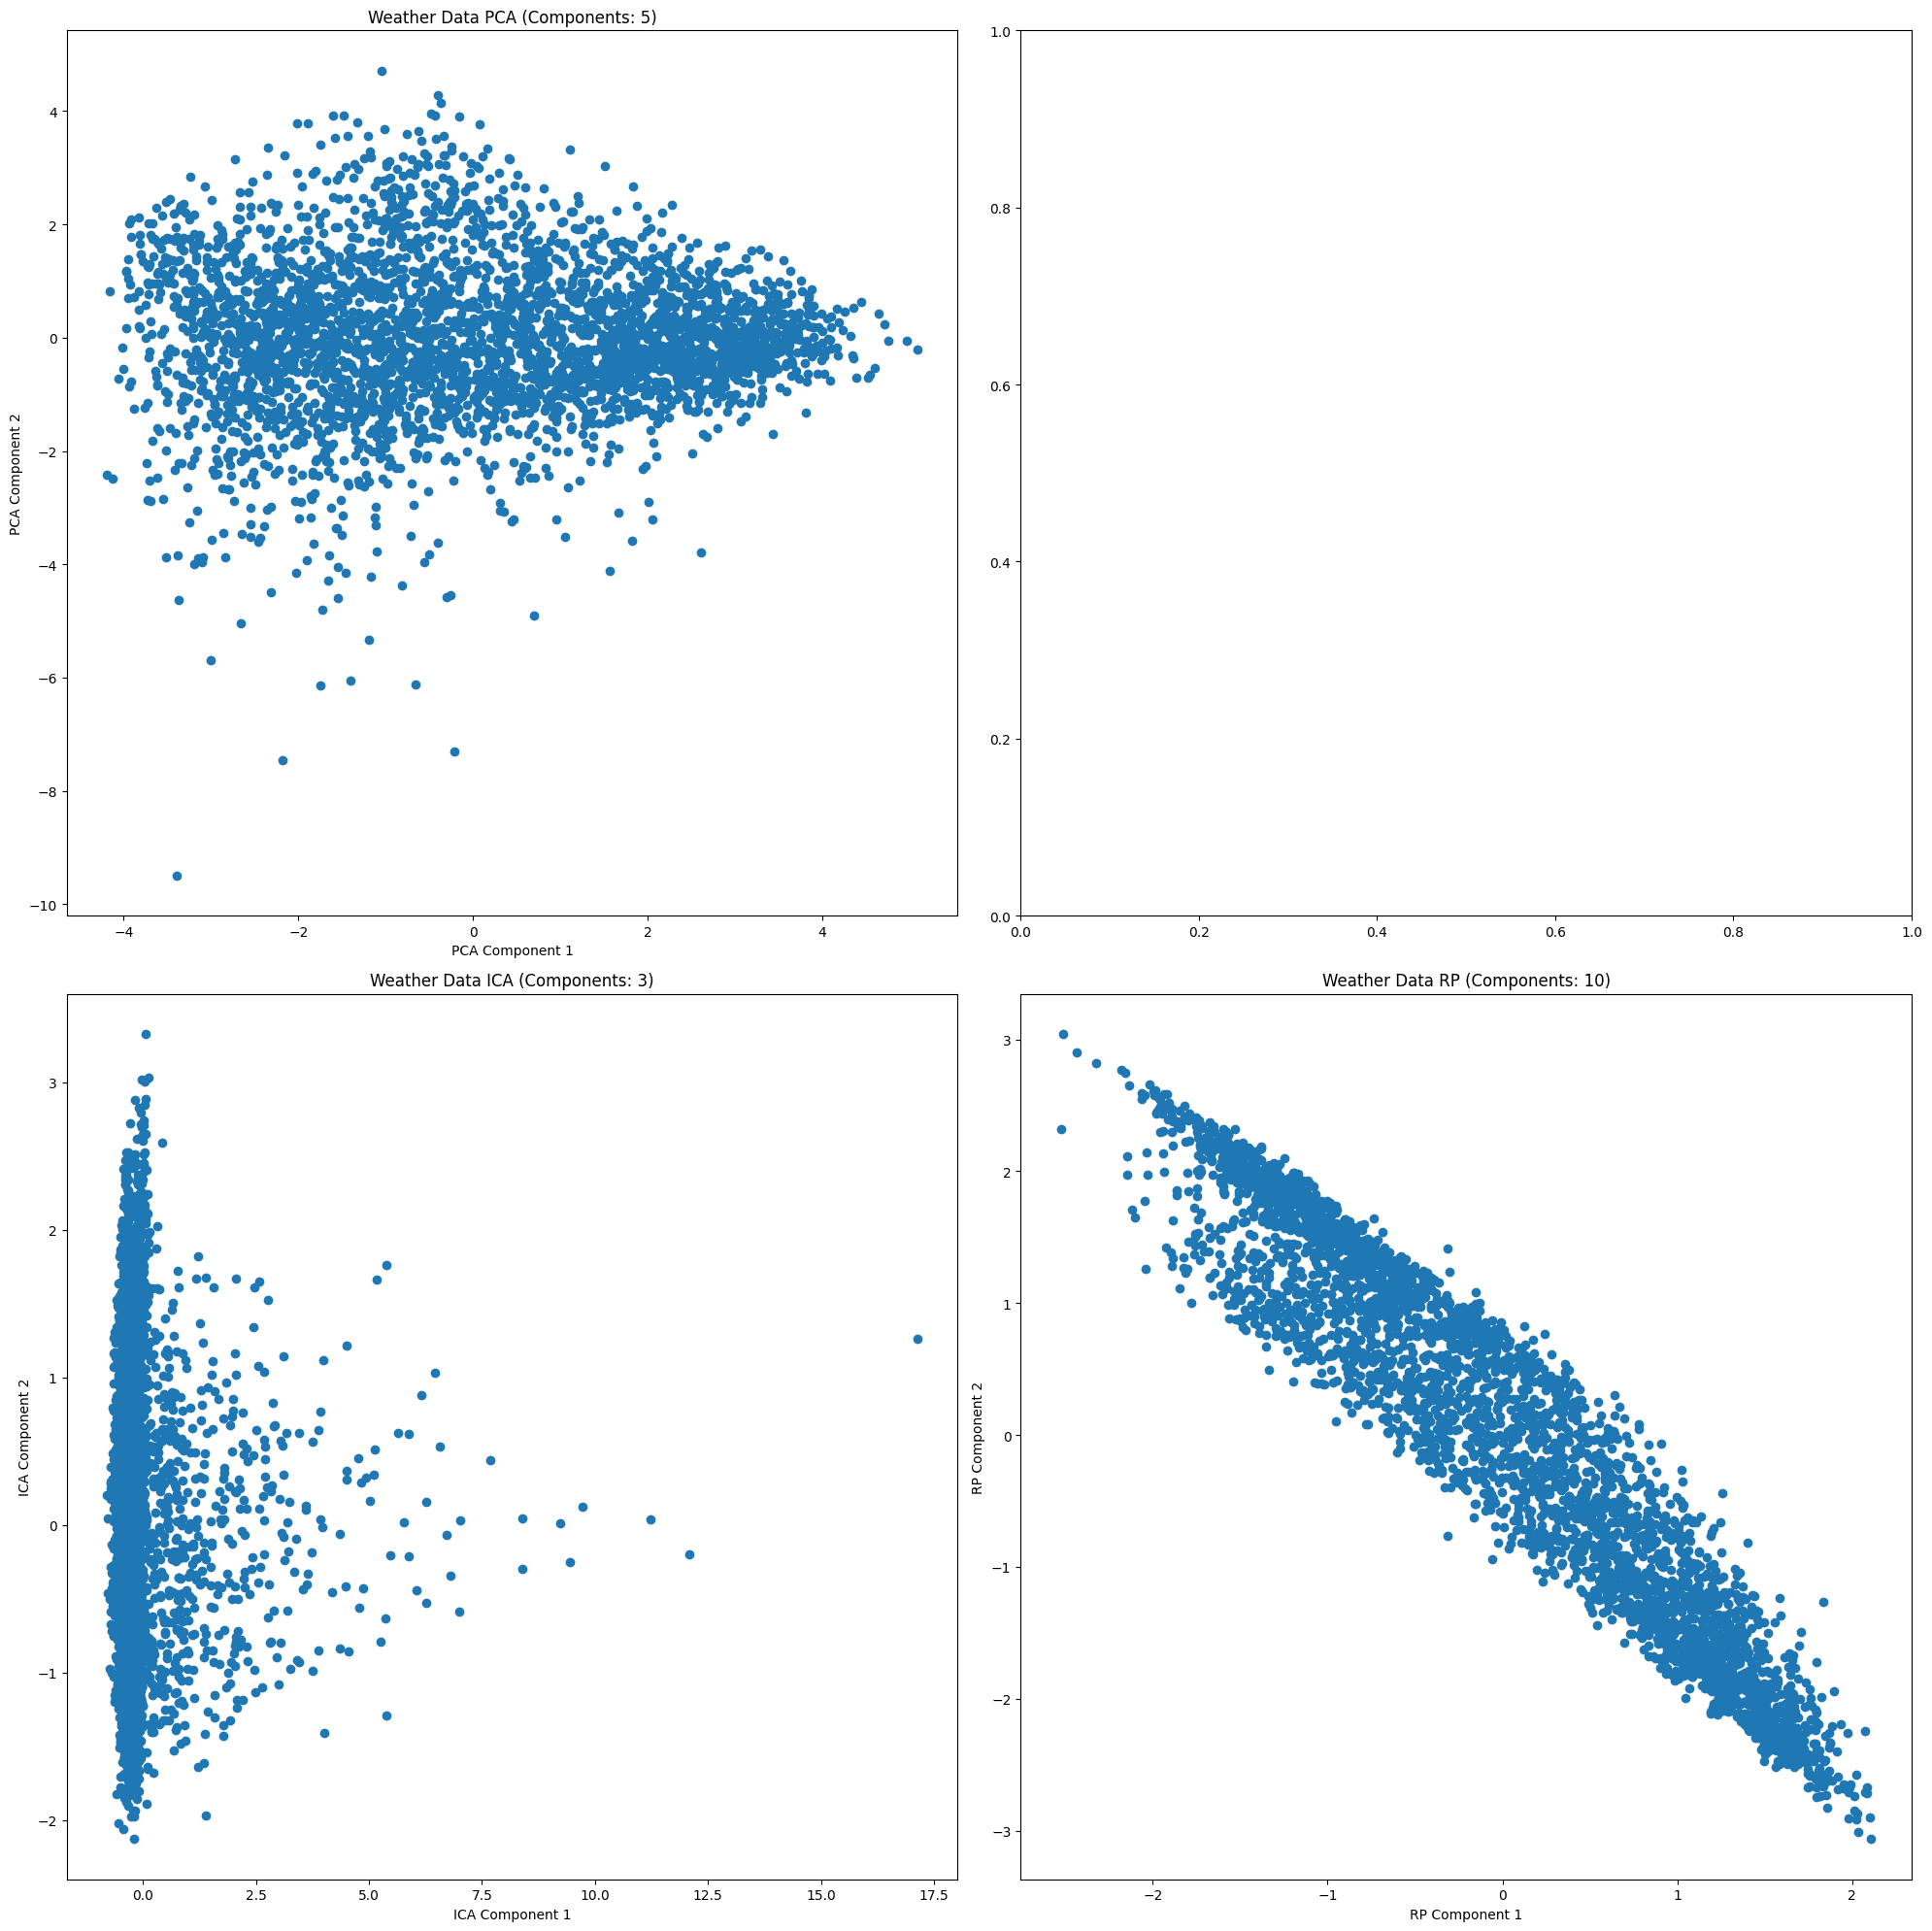

In [13]:
pca_weather, pca_components_weather = optimal_pca_components(normalized_features)
ica_weather, ica_components_weather = optimal_ica_components(normalized_features)
rp_weather, rp_components_weather = apply_rp(normalized_features)

# plot all in one figure
fig, axes = plt.subplots(2, 2, figsize=(20, 20))
axes[0,0].scatter(pca_weather[:, 0], pca_weather[:, 1], cmap='viridis', marker='o')
axes[0,0].set_title(f'Weather Data PCA (Components: {pca_components_weather})')
axes[0,0].set_xlabel('PCA Component 1')
axes[0,0].set_ylabel('PCA Component 2')

axes[1,0].scatter(ica_weather[:, 0], ica_weather[:, 1], cmap='viridis', marker='o')
axes[1,0].set_title(f'Weather Data ICA (Components: {ica_components_weather})')
axes[1,0].set_xlabel('ICA Component 1')
axes[1,0].set_ylabel('ICA Component 2')

axes[1,1].scatter(rp_weather[:, 0], rp_weather[:, 1], cmap='viridis', marker='o')
axes[1,1].set_title(f'Weather Data RP (Components: {rp_components_weather})')
axes[1,1].set_xlabel('RP Component 1')
axes[1,1].set_ylabel('RP Component 2')

plt.tight_layout()
plt.show()

## Reapplying Clustering Algorithms to Dimensionality Reduction Datasets

### Principal Component Analysis (PCA)

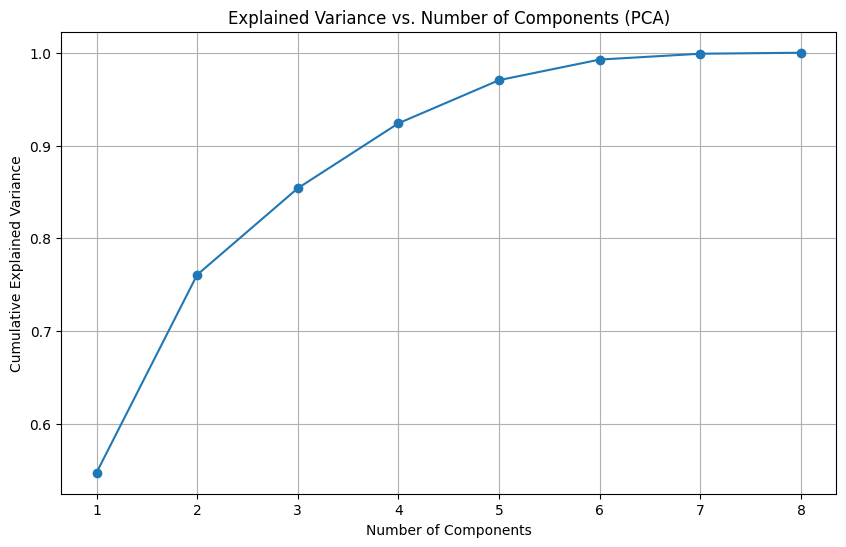

In [18]:
pca_weather, pca_components_weather = optimal_pca_components(normalized_features)

### Independent Component Analysis (ICA)

/Users/atomar/Desktop/CSE 7641_ML/Housing_Weather_UL_Dim_Reduction/venv/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:595: UserWarning: n_components is too large: it will be set to 8
  warnings.warn(
/Users/atomar/Desktop/CSE 7641_ML/Housing_Weather_UL_Dim_Reduction/venv/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:595: UserWarning: n_components is too large: it will be set to 8
  warnings.warn(


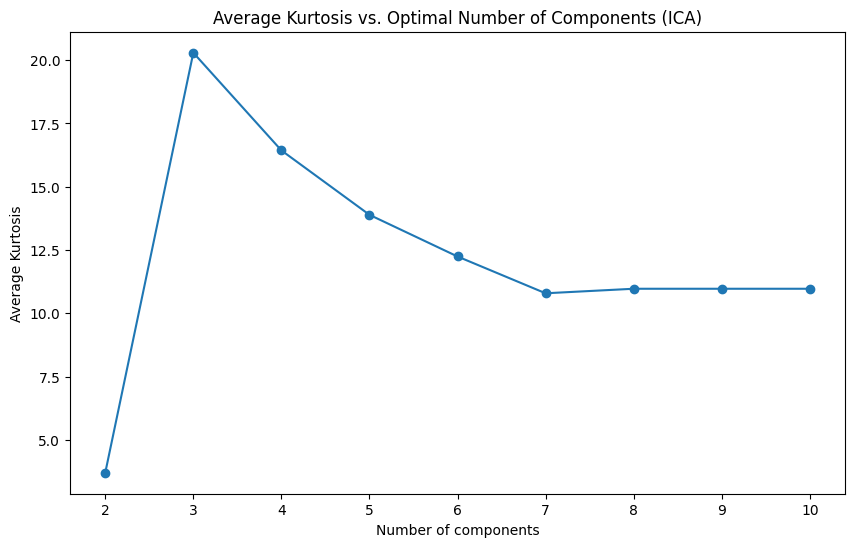

In [19]:
ica_weather, ica_components_weather = optimal_ica_components(normalized_features)

### Random Projection (PCA)

/Users/atomar/Desktop/CSE 7641_ML/Housing_Weather_UL_Dim_Reduction/venv/lib/python3.9/site-packages/sklearn/random_projection.py:408: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (8 < 9).The dimensionality of the problem will not be reduced.
  warnings.warn(
/Users/atomar/Desktop/CSE 7641_ML/Housing_Weather_UL_Dim_Reduction/venv/lib/python3.9/site-packages/sklearn/random_projection.py:408: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (8 < 10).The dimensionality of the problem will not be reduced.
  warnings.warn(


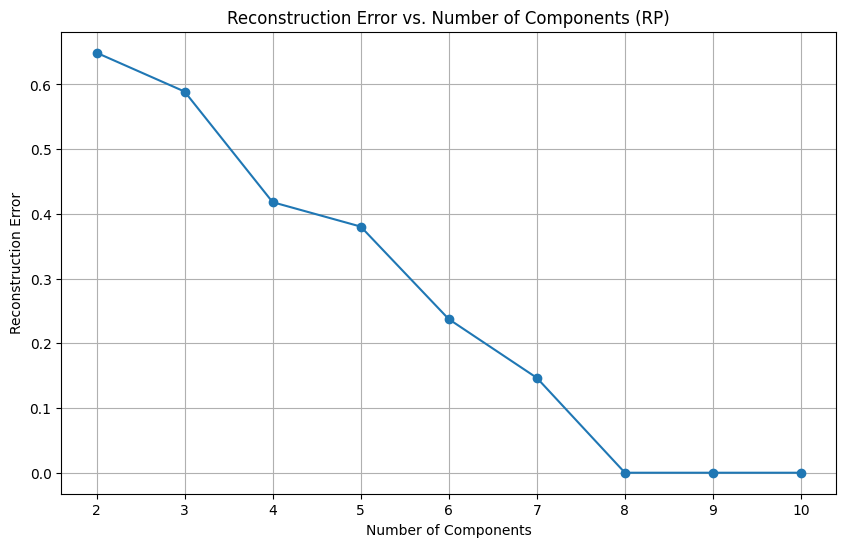

/Users/atomar/Desktop/CSE 7641_ML/Housing_Weather_UL_Dim_Reduction/venv/lib/python3.9/site-packages/sklearn/random_projection.py:408: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (8 < 10).The dimensionality of the problem will not be reduced.
  warnings.warn(


In [20]:
rp_weather, rp_components_weather = apply_rp(normalized_features)

### Clustering after Dimensionality Reduction

In [21]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

def find_optimal_k_elbow(features):
    wcss = []
    k_range = range(1, 11)
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(features)
        wcss.append(kmeans.inertia_)
    
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, wcss, marker='o')
    plt.xlabel('Number of Clusters')
    plt.ylabel('WCSS')
    plt.title('Elbow Method for Optimal k')
    plt.grid(True)
    plt.show()
    
    optimal_k = 3  # Assuming the elbow is at k=3 for simplicity
    return optimal_k

def find_optimal_k_silhouette(features):
    silhouette_scores = []
    k_range = range(2, 11)
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        cluster_labels = kmeans.fit_predict(features)
        silhouette_avg = silhouette_score(features, cluster_labels)
        silhouette_scores.append(silhouette_avg)
    
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, silhouette_scores, marker='o')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score for Optimal k')
    plt.grid(True)
    plt.show()
    
    optimal_k = k_range[np.argmax(silhouette_scores)]
    return optimal_k

def apply_kmeans(features, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(features)
    return clusters

def apply_em(features, n_components):
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    clusters = gmm.fit_predict(features)
    return clusters

def evaluate_clustering(features, labels):
    silhouette_avg = silhouette_score(features, labels)
    davies_bouldin_avg = davies_bouldin_score(features, labels)
    calinski_harabasz_avg = calinski_harabasz_score(features, labels)
    return silhouette_avg, davies_bouldin_avg, calinski_harabasz_avg

def apply_and_evaluate_clustering(features, name):
    results = {}

    # Find optimal k
    optimal_k = find_optimal_k_silhouette(features)
    
    # Apply KMeans and EM
    kmeans_clusters = apply_kmeans(features, optimal_k)
    em_clusters = apply_em(features, optimal_k)

    # Evaluate KMeans
    silhouette_kmeans, davies_bouldin_kmeans, calinski_harabasz_kmeans = evaluate_clustering(features, kmeans_clusters)
    results[f'KMeans_{name}'] = (silhouette_kmeans, davies_bouldin_kmeans, calinski_harabasz_kmeans)

    # Evaluate EM
    silhouette_em, davies_bouldin_em, calinski_harabasz_em = evaluate_clustering(features, em_clusters)
    results[f'EM_{name}'] = (silhouette_em, davies_bouldin_em, calinski_harabasz_em)

    return results


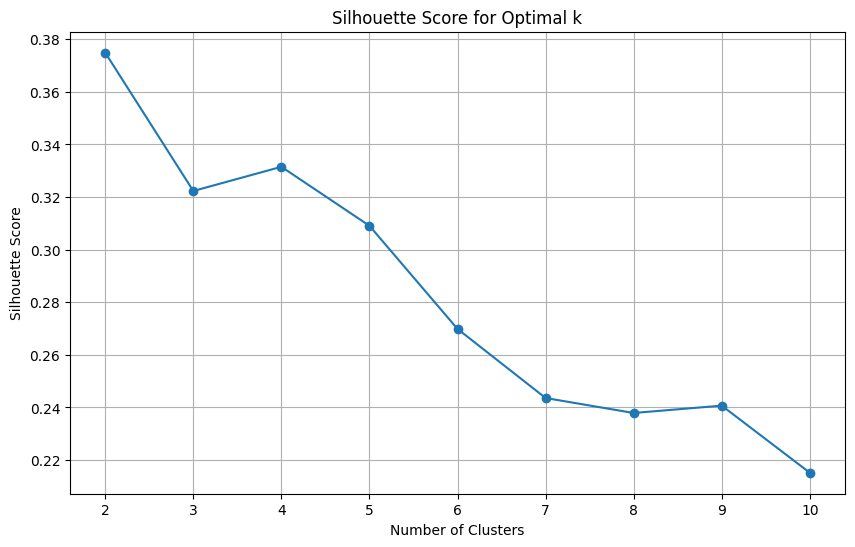

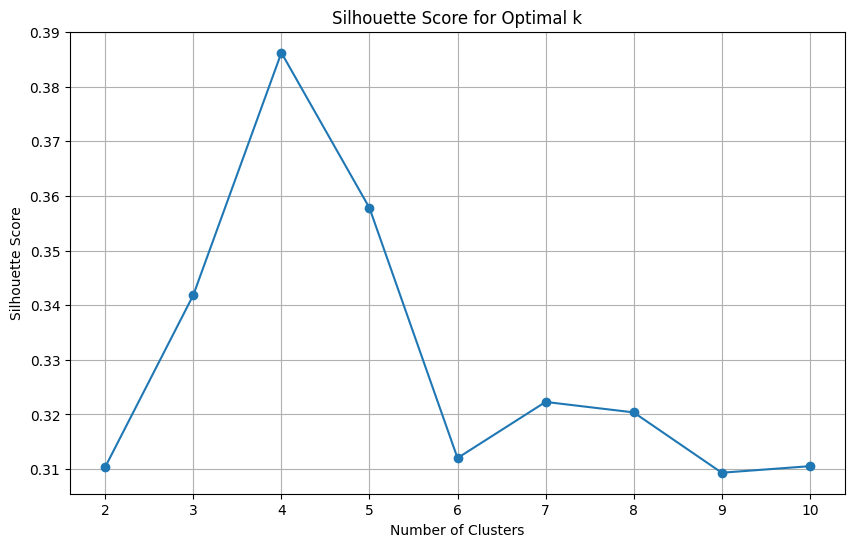

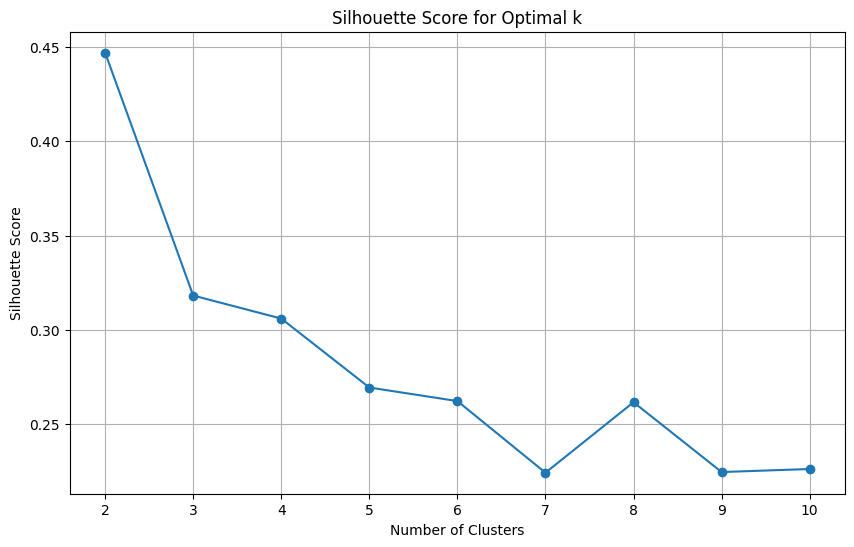

In [22]:
reduction_methods = {
    'PCA': pca_weather,
    'ICA': ica_weather,
    'RP': rp_weather
}

# Store and evaluate clustering results
all_results = {}
for name, features in reduction_methods.items():
    results = apply_and_evaluate_clustering(features, name)
    all_results.update(results)


### Plotting Performance Metrics

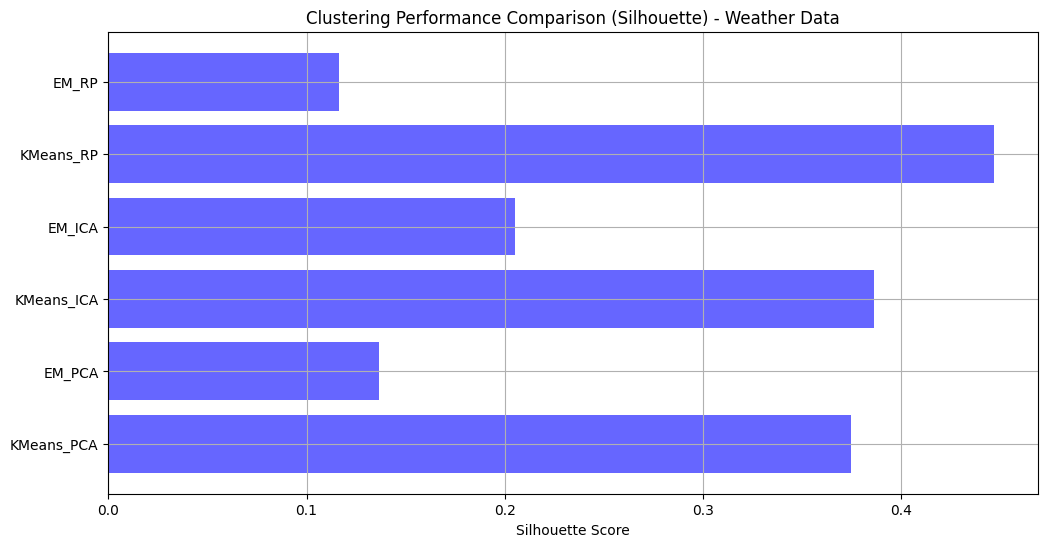

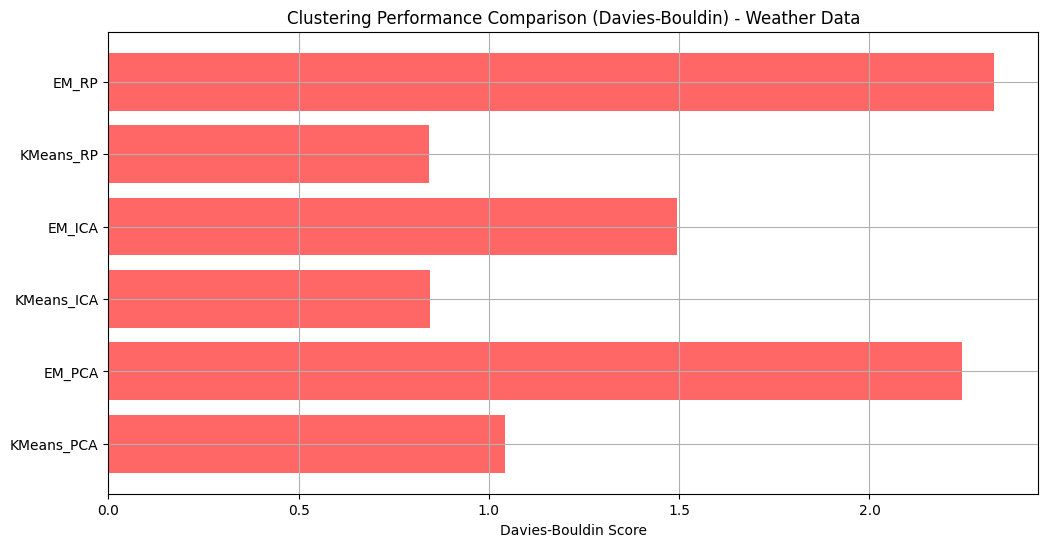

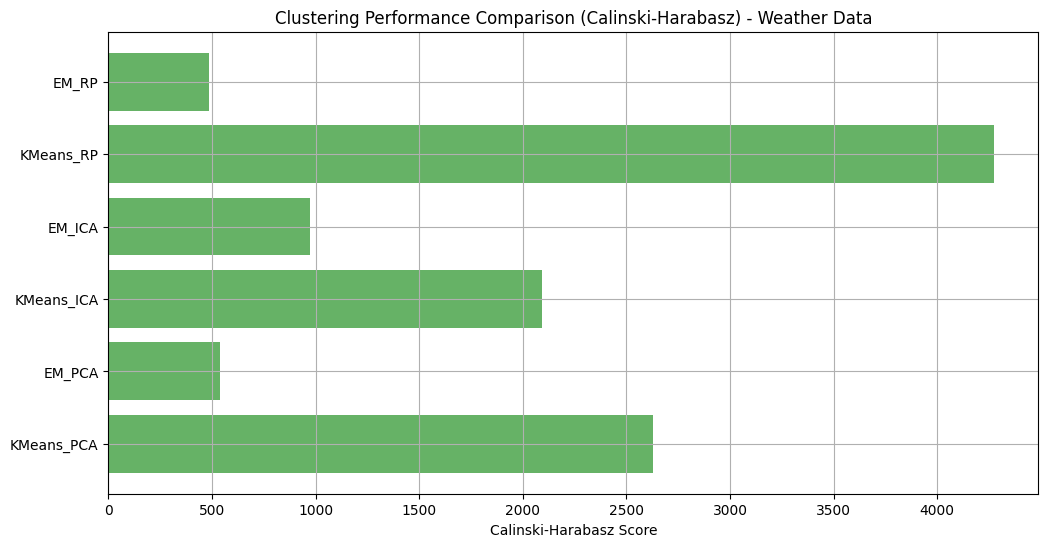

In [23]:
# Extract metric names and values
methods = list(all_results.keys())
silhouette_scores = [all_results[method][0] for method in methods]
davies_bouldin_scores = [all_results[method][1] for method in methods]
calinski_harabasz_scores = [all_results[method][2] for method in methods]

# Plot the results
plt.figure(figsize=(12, 6))
plt.barh(methods, silhouette_scores, color='b', alpha=0.6)
plt.xlabel('Silhouette Score')
plt.title('Clustering Performance Comparison (Silhouette) - Weather Data')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.barh(methods, davies_bouldin_scores, color='r', alpha=0.6)
plt.xlabel('Davies-Bouldin Score')
plt.title('Clustering Performance Comparison (Davies-Bouldin) - Weather Data')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.barh(methods, calinski_harabasz_scores, color='g', alpha=0.6)
plt.xlabel('Calinski-Harabasz Score')
plt.title('Clustering Performance Comparison (Calinski-Harabasz) - Weather Data')
plt.grid(True)
plt.show()